# Finite elements for IVBP with Neumann conditions

## Start simple: BVP with Neumann BC

Example 6.10 - Inhomogeneous Neumann BVP

This example is taken from Gockenbach, Sect. 6.5.

In [396]:
from sympy import *
init_printing(use_unicode=True)

In [397]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.linalg import solve_banded

In [398]:
init_session()

IPython console for SymPy 1.10.1 (Python 3.9.12-64-bit) (ground types: python)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.10.1/



In [399]:
u = symbols('u', cls=Function)
l = Symbol('l', real=True, positive=True)
i = Symbol('i', integer=True)
h = Symbol('h', real=True, positive=True)

In [400]:
ode = Eq((-u(x).diff(x, x)),(x-1/2), domain=Interval(0,1))

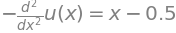

In [401]:
ode

In [402]:
ics = {
    u(x).diff(x).subs(x, 0) : 0,
    u(x).diff(x).subs(x, l) : 0,
    u(0) : 0,
}

In [403]:
srepr(ode)

"Equality(Mul(Integer(-1), Derivative(Function('u')(Symbol('x')), Tuple(Symbol('x'), Integer(2)))), Add(Symbol('x'), Float('-0.5', precision=53)))"

In [404]:
def basis(x, i):
    return np.piecewise(x, [x < (i-1)*h,
                            ((i-1)*h <= x) & (x <= i*h),
                            (i*h < x) & (x <= (i+1)*h),
                            x > (i+1)*h],
                        [0, (x - (i - 1) * h)/h, -(x - (i + 1) * h)/h, 0])

vbasis = np.vectorize(basis)

## Build the piecewise polynomials basis

The following is a single element $\phi_j (x)$ of the basis of piecewise polynomials. This means that, when building the matrixes $\textbf{K}_{ij}$ and $\textbf{M}_{ij}$, one has to take into account to loop on the j index as a function of the i index.

In [405]:
sy_basis = Piecewise(
    (x/h-i+1, (x>(i-1)*h)&(x<i*h)),
    (-x/h+i+1, (x>i*h)&(x<(i+1)*h)),
    (0, True),
); sy_basis

⎧         x                             
⎪-i + 1 + ─  for x > h⋅(i - 1) ∧ x < h⋅i
⎪         h                             
⎪                                       
⎨        x                              
⎪i + 1 - ─   for x > h⋅i ∧ x < h⋅(i + 1)
⎪        h                              
⎪                                       
⎩    0                otherwise         

In [406]:
sy_basis2 = sy_basis**2; sy_basis2

⎧            2                             
⎪⎛         x⎞                              
⎪⎜-i + 1 + ─⎟   for x > h⋅(i - 1) ∧ x < h⋅i
⎪⎝         h⎠                              
⎪                                          
⎨           2                              
⎪⎛        x⎞                               
⎪⎜i + 1 - ─⎟    for x > h⋅i ∧ x < h⋅(i + 1)
⎪⎝        h⎠                               
⎪                                          
⎩      0                 otherwise         

In [407]:
sy_basis2.integrate(x)

⎧                                                                             
⎪                                                                             
⎪                                                                             
⎪                                                                  2   h⋅(i - 
⎪                                               - h⋅(1 - i)⋅(i - 1)  - ───────
⎪                                                                          3  
⎪                                                                             
⎪                                                                             
⎪                                                                             
⎨              2              2                ⎛ 2          ⎞       ⎛ 2       
⎪           h⋅i ⋅(1 - i) - h⋅i ⋅(-i - 1) + h⋅i⋅⎝i  - 2⋅i + 1⎠ - h⋅i⋅⎝i  + 2⋅i 
⎪                                                                             
⎪                                                   

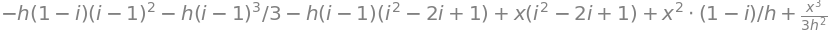

In [408]:
sy_basis2.integrate(x).args[1][0]

In [409]:
sy_dbasis = Derivative(sy_basis, x).doit(); sy_dbasis

⎧ 1                              
⎪ ─   for x > h⋅(i - 1) ∧ x < h⋅i
⎪ h                              
⎪                                
⎨-1                              
⎪───  for x > h⋅i ∧ x < h⋅(i + 1)
⎪ h                              
⎪                                
⎩ 0            otherwise         

In [410]:
sy_dbasis2 = sy_dbasis**2; sy_dbasis2

⎧1                                                                            
⎪──  for (x > h⋅i ∨ x > h⋅(i - 1)) ∧ (x > h⋅i ∨ x < h⋅i) ∧ (x > h⋅(i - 1) ∨ x 
⎪ 2                                                                           
⎨h                                                                            
⎪                                                                             
⎪0                                                       otherwise            
⎩                                                                             

                                        
< h⋅(i + 1)) ∧ (x < h⋅i ∨ x < h⋅(i + 1))
                                        
                                        
                                        
                                        
                                        

In [411]:
sy_dbasis2.piecewise_integrate(x)

⎧x                                                                            
⎪──  for (x > h⋅i ∨ x > h⋅(i - 1)) ∧ (x > h⋅i ∨ x < h⋅i) ∧ (x > h⋅(i - 1) ∨ x 
⎪ 2                                                                           
⎨h                                                                            
⎪                                                                             
⎪0                                                       otherwise            
⎩                                                                             

                                        
< h⋅(i + 1)) ∧ (x < h⋅i ∨ x < h⋅(i + 1))
                                        
                                        
                                        
                                        
                                        

### 1st element of the basis

Consider $\phi_j(x_i)$ with j = 1. Then the integer variable i = j. \
Elements $\phi_0$ and $\phi_n$ are to be defined indipendently from the others with i = 1, ... , n-1.

In [412]:
# Take the general definition of the basis and substitute i = 1
e1 = sy_basis.subs(i, 1); e1

⎧  x                       
⎪  ─     for h > x ∧ x > 0 
⎪  h                       
⎪                          
⎨    x                     
⎪2 - ─  for h < x ∧ x < 2⋅h
⎪    h                     
⎪                          
⎩  0         otherwise     

In [413]:
de1_2 = sy_dbasis2.subs(i,1); de1_2

⎧1                                                                            
⎪──  for (h > x ∨ h < x) ∧ (h > x ∨ x < 2⋅h) ∧ (x > 0 ∨ h < x) ∧ (x > 0 ∨ x < 
⎪ 2                                                                           
⎨h                                                                            
⎪                                                                             
⎪0                                     otherwise                              
⎩                                                                             

    
2⋅h)
    
    
    
    
    

In [414]:
de1_2.integrate((x, 0, 2*h))

And this, my man, is the entry 11 of the stiffness matrix. Time to make this object-oriented and cycle over the indexes.

### Construction of the entries of the K matrix

In [415]:
# Build the main diagonal first
for n in [m+1 for m in range(10)]:
    dummy = sy_dbasis2.subs(i,n).integrate((x, (n-1)*h, (n+1)*h))
    print(dummy)

2/h
2/h
2/h
2/h
2/h
2/h
2/h
2/h
2/h
2/h


In [416]:
e0 = Piecewise(
    (-x/h+i+1, (x>0)&(x<h)),
    (0, True),
); e0

⎧        x                   
⎪i + 1 - ─  for h > x ∧ x > 0
⎨        h                   
⎪                            
⎩    0          otherwise    

### Last try to see if I can implement some sort of inner product

**Note: the following is just for trying and is not related to the computation of matrix K: in fact, it uses the elements of the basis and not their derivatives.**

In [417]:
# Build the second element of the basis
e2 = sy_basis.subs(i, 2); e2

⎧     x                       
⎪-1 + ─   for h < x ∧ x < 2⋅h 
⎪     h                       
⎪                             
⎨    x                        
⎪3 - ─   for x > 2⋅h ∧ x < 3⋅h
⎪    h                        
⎪                             
⎩  0           otherwise      

**WARNING** \ The result below is by no means correct: this may be due to the order of the 

In [418]:
# Compute the product of e1 and e2
e1e2 = e1*e2; e1e2
e1e2.evalf()

⎛⎧   x                        ⎞ ⎛⎧       x                       ⎞
⎜⎪   ─      for h > x ∧ x > 0 ⎟ ⎜⎪-1.0 + ─   for h < x ∧ x < 2⋅h ⎟
⎜⎪   h                        ⎟ ⎜⎪       h                       ⎟
⎜⎪                            ⎟ ⎜⎪                               ⎟
⎜⎨      x                     ⎟⋅⎜⎨      x                        ⎟
⎜⎪2.0 - ─  for h < x ∧ x < 2⋅h⎟ ⎜⎪3.0 - ─   for x > 2⋅h ∧ x < 3⋅h⎟
⎜⎪      h                     ⎟ ⎜⎪      h                        ⎟
⎜⎪                            ⎟ ⎜⎪                               ⎟
⎝⎩   0          otherwise     ⎠ ⎝⎩   0            otherwise      ⎠

In [419]:
integrate(e1*e2, (x, 0, 2*h))

In [420]:
type(e1e2)

sympy.core.mul.Mul

## B-spline tries

In [421]:
d = 1 # degree pf the B-splines
knots = tuple(range(10)); len(knots)

In [422]:
bspline_basis(d, knots, 7, x)

⎧x - 7  for x ≥ 7 ∧ x ≤ 8
⎪                        
⎨9 - x  for x ≥ 8 ∧ x ≤ 9
⎪                        
⎩  0        otherwise    

## Implementing matrix representation of piecewise linear polynomials basis

Consider a uniformly spaced grid on the x axis, with n+1 nodes $x_i$, such that $x_0 = 0$ and $x_n = l$. Then consider the piecewise polynomials: every element $\phi_j$ takes some value in every interval, and this value can be viewed as the entry of a vector of n components. \
Ex. $\phi_0 = [-\frac{x}{h}+1, 0, 0, ..., 0]$ \
We can build a matrix whose rows are the vectors that represent the piecewise polynomials in the form that we have showed. With this convention, we have n+1 rows that represent the piecewise polynomials, and n columns, one for every interval.

In [423]:
sy_basis

⎧         x                             
⎪-i + 1 + ─  for x > h⋅(i - 1) ∧ x < h⋅i
⎪         h                             
⎪                                       
⎨        x                              
⎪i + 1 - ─   for x > h⋅i ∧ x < h⋅(i + 1)
⎪        h                              
⎪                                       
⎩    0                otherwise         

In [424]:
# The first (and only) element of the e0 component
# From now on, the elements of the basis are called eX, with X their index,
# eXY are the entries of the matrix built with the vectors eX,
# deXY are the elements of the matrix of the derivatives,
# eXeY are the elements of the matrix that has the scalar products as components

# e00 = sy_basis.args[1][0]; e00 # this assignment leads to incompatibility
                                    # with other expressions and simplification
e00 = -x/h + i + S.One; e00

In [425]:
# enn = sy_basis.args[0][0]; enn
enn = x/h - i + S.One; enn

In [426]:
# Fix number of intervals
n = 10

In [427]:
# Build the matrix from scratch: it is a rectangular matrix.
# The matrix can be viewed as a square matrix with "descending" values
# (negative derivative) on the main diagonal, and a single off-diag
# with "ascending" values, below the main diagonal. Then we add the
# n+1 row that only contains the 

eii = np.ones(n+1)*e00; eii

array([1.0*i + 1.0 - 1.0*x/h, 1.0*i + 1.0 - 1.0*x/h,
       1.0*i + 1.0 - 1.0*x/h, 1.0*i + 1.0 - 1.0*x/h,
       1.0*i + 1.0 - 1.0*x/h, 1.0*i + 1.0 - 1.0*x/h,
       1.0*i + 1.0 - 1.0*x/h, 1.0*i + 1.0 - 1.0*x/h,
       1.0*i + 1.0 - 1.0*x/h, 1.0*i + 1.0 - 1.0*x/h,
       1.0*i + 1.0 - 1.0*x/h], dtype=object)

In [428]:
eii_1 = np.ones(n)*enn; eii_1

array([-1.0*i + 1.0 + 1.0*x/h, -1.0*i + 1.0 + 1.0*x/h,
       -1.0*i + 1.0 + 1.0*x/h, -1.0*i + 1.0 + 1.0*x/h,
       -1.0*i + 1.0 + 1.0*x/h, -1.0*i + 1.0 + 1.0*x/h,
       -1.0*i + 1.0 + 1.0*x/h, -1.0*i + 1.0 + 1.0*x/h,
       -1.0*i + 1.0 + 1.0*x/h, -1.0*i + 1.0 + 1.0*x/h], dtype=object)

In [429]:
shape(np.diag(eii_1))

In [430]:
shape(np.diag(eii))

In [431]:
# This is ok but from here I cannot access the entries

e = Matrix(np.diag(eii) + np.diag(eii_1, -1)); e

⎡              x                                                              
⎢1.0⋅i + 1.0 - ─          0                 0                 0               
⎢              h                                                              
⎢                                                                             
⎢           1.0⋅x                x                                            
⎢-i + 1.0 + ─────  1.0⋅i + 1.0 - ─          0                 0               
⎢             h                  h                                            
⎢                                                                             
⎢                             1.0⋅x                x                          
⎢       0          -i + 1.0 + ─────  1.0⋅i + 1.0 - ─          0               
⎢                               h                  h                          
⎢                                                                             
⎢                                               1.0⋅

In [432]:
m = np.diag(eii_1, -1) + np.diag(eii); m

array([[1.0*i + 1.0 - 1.0*x/h, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [-1.0*i + 1.0 + 1.0*x/h, 1.0*i + 1.0 - 1.0*x/h, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, -1.0*i + 1.0 + 1.0*x/h, 1.0*i + 1.0 - 1.0*x/h, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, -1.0*i + 1.0 + 1.0*x/h, 1.0*i + 1.0 - 1.0*x/h, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, -1.0*i + 1.0 + 1.0*x/h, 1.0*i + 1.0 - 1.0*x/h, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, -1.0*i + 1.0 + 1.0*x/h, 1.0*i + 1.0 - 1.0*x/h, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, -1.0*i + 1.0 + 1.0*x/h, 1.0*i + 1.0 - 1.0*x/h, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, -1.0*i + 1.0 + 1.0*x/h, 1.0*i + 1.0 - 1.0*x/h,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, -1.0*i + 1.0 + 1.0*x/h,
        1.0*i + 1.0 - 1.0*x/h, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, -1.0*i + 1.0 + 1.0*x/h,
        1.0*i + 1.0 - 1.0*x/h, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, -1.0*i + 1.0 + 1.0*x/h,
        1.0*i + 1.0 - 1.0*x/h]], dtype=object)

In [433]:
e = zeros(n+1, n); e;

In [434]:
lambdify(args=[x,h,i], expr=e00, modules=["numpy"])

<function _lambdifygenerated(x, h, i)>

In [435]:
i = Symbol("i", integer=True)

In [436]:
n = 10

# We build the matrix of the elements starting from a list of lists:
# each sublist is filled with conditional statements with the
# sympy objects e00 and enn that represent the values of the pp basis'
# elements in a given interval (represented by index j). The index i
# loops on the pp basis (from 0 to n) and is substituted in the expr
# e00 and enn. What we obtain is a pure sympy.Matrix object.

elist = []
for a in range(n+1):
    lista = [0 for b in range(n)]
    for b in range(n):
        if (a!=0)&(b==a-1): lista[b]=enn.subs(i, a)
        elif a==b: lista[b]=e00.subs(i, a)
        else: lista[b]=0
    elist.append(lista)
e = Matrix(elist); e

⎡    x                                                                        
⎢1 - ─    0       0       0       0       0       0       0       0       0   
⎢    h                                                                        
⎢                                                                             
⎢  x        x                                                                 
⎢  ─    2 - ─     0       0       0       0       0       0       0       0   
⎢  h        h                                                                 
⎢                                                                             
⎢            x      x                                                         
⎢  0    -1 + ─  3 - ─     0       0       0       0       0       0       0   
⎢            h      h                                                         
⎢                                                                             
⎢                    x      x                       

In [437]:
e00.diff(x)

In [438]:
# We build the matrix of the derivatives in the same way as we have built
# the matrix of the elements.

delist = []
for a in range(n+1):
    lista = [0 for b in range(n)]
    for b in range(n):
        if (a!=0)&(b==a-1): lista[b]=enn.diff(x)
        elif a==b: lista[b]=e00.diff(x)
        else: lista[b]=0
    delist.append(lista)
de = Matrix(delist); de

⎡-1                                              ⎤
⎢───   0    0    0    0    0    0    0    0    0 ⎥
⎢ h                                              ⎥
⎢                                                ⎥
⎢ 1   -1                                         ⎥
⎢ ─   ───   0    0    0    0    0    0    0    0 ⎥
⎢ h    h                                         ⎥
⎢                                                ⎥
⎢      1   -1                                    ⎥
⎢ 0    ─   ───   0    0    0    0    0    0    0 ⎥
⎢      h    h                                    ⎥
⎢                                                ⎥
⎢           1   -1                               ⎥
⎢ 0    0    ─   ───   0    0    0    0    0    0 ⎥
⎢           h    h                               ⎥
⎢                                                ⎥
⎢                1   -1                          ⎥
⎢ 0    0    0    ─   ───   0    0    0    0    0 ⎥
⎢                h    h                          ⎥
⎢                              

In [439]:
# Checking that the shape is the one that we want

shape(de)

In [440]:
# And now try to implement the damn scalar product as a matrix product
# of the de matrix and de.T. The resulting matrix is the matrix of the
# integrands of the matrix Kij, and we should call it Iij

Iij = de*de.T; Iij

⎡1    -1                                              ⎤
⎢──   ───   0    0    0    0    0    0    0    0    0 ⎥
⎢ 2     2                                             ⎥
⎢h     h                                              ⎥
⎢                                                     ⎥
⎢-1   2    -1                                         ⎥
⎢───  ──   ───   0    0    0    0    0    0    0    0 ⎥
⎢  2   2     2                                        ⎥
⎢ h   h     h                                         ⎥
⎢                                                     ⎥
⎢     -1   2    -1                                    ⎥
⎢ 0   ───  ──   ───   0    0    0    0    0    0    0 ⎥
⎢       2   2     2                                   ⎥
⎢      h   h     h                                    ⎥
⎢                                                     ⎥
⎢          -1   2    -1                               ⎥
⎢ 0    0   ───  ──   ───   0    0    0    0    0    0 ⎥
⎢            2   2     2                        

In [441]:
# Access elements

Iij.row(0)[0]

In [442]:
Iij.row(0)[0].integrate((x, 0, h))

In [443]:
# Try function min(x,y)

a, b = 1, 2
min(a,b)

In [444]:
len(Iij.row(0))

In [445]:
# Now we build the stiffness matrix Kij.
# Notice that since every interval is of the same width h, we can just
# integrate each entry of the Iij matrix between 0 and h.
# If you want to use a non-linearly spaced grid for the xj nodes,
# you have to modify dynamically the integration limits inside the
# tuple (x, min, max) passed as an argument to Matrix.integrate()

klist = []
for a in range(len(Iij.col(0))):
    lista = [0 for b in range(len(Iij.row(0)))]
    for b,_ in enumerate(lista):
        lista[b] = Iij.row(a)[b].integrate((x, 0, h))
    klist.append(lista)

Kij = Matrix(klist); Kij

⎡ 1   -1                                              ⎤
⎢ ─   ───   0    0    0    0    0    0    0    0    0 ⎥
⎢ h    h                                              ⎥
⎢                                                     ⎥
⎢-1    2   -1                                         ⎥
⎢───   ─   ───   0    0    0    0    0    0    0    0 ⎥
⎢ h    h    h                                         ⎥
⎢                                                     ⎥
⎢     -1    2   -1                                    ⎥
⎢ 0   ───   ─   ───   0    0    0    0    0    0    0 ⎥
⎢      h    h    h                                    ⎥
⎢                                                     ⎥
⎢          -1    2   -1                               ⎥
⎢ 0    0   ───   ─   ───   0    0    0    0    0    0 ⎥
⎢           h    h    h                               ⎥
⎢                                                     ⎥
⎢               -1    2   -1                          ⎥
⎢ 0    0    0   ───   ─   ───   0    0    0    0

## Implementing vector representation of rhs function

In [446]:
# The rhs function may be defined as a sympy object

rhs = x - Rational(1,2); rhs

In [447]:
# The matrix (vector) of the integrands have to be built in the
# same way as we have to be built in the same way in which
# we have built the other matrixes, via a list of lists.

# We go step by step to make the procedure clear:
# 1. build the matrix of the integrand functions

Iflist = []
for a in range(n+1):
    lista = [0 for b in range(n)]
    for b in range(n):
        if (a!=0)&(b==a-1): lista[b]=enn.subs(i, a)*rhs
        elif a==b: lista[b]=e00.subs(i, a)*rhs
        else: lista[b]=0
    Iflist.append(lista)
If = Matrix(Iflist); If

⎡⎛    x⎞                                                                      
⎢⎜1 - ─⎟⋅(x - 1/2)          0                   0                   0         
⎢⎝    h⎠                                                                      
⎢                                                                             
⎢   x⋅(x - 1/2)     ⎛    x⎞                                                   
⎢   ───────────     ⎜2 - ─⎟⋅(x - 1/2)           0                   0         
⎢        h          ⎝    h⎠                                                   
⎢                                                                             
⎢                   ⎛     x⎞            ⎛    x⎞                               
⎢        0          ⎜-1 + ─⎟⋅(x - 1/2)  ⎜3 - ─⎟⋅(x - 1/2)           0         
⎢                   ⎝     h⎠            ⎝    h⎠                               
⎢                                                                             
⎢                                       ⎛     x⎞    

In [457]:
# 2. build the matrix with the result of the integration of each
# integrand function (per interval, per piecewise element)

fflist = []
for a in range(n+1):
    lista = [0 for b in range(n)]
    for b in range(n):
        if (a==0) or (a==n): lista[b]=expand(If.row(a)[b].integrate((x, S.Zero, h)))
        else: lista[b]=expand(If.row(a)[b].integrate((x, b*h, (b+1)*h)))
    fflist.append(lista)
fij = Matrix(fflist); fij

⎡ 2                                                                           
⎢h    h                                                                       
⎢── - ─     0         0          0          0          0          0          0
⎢6    4                                                                       
⎢                                                                             
⎢ 2         2                                                                 
⎢h    h  2⋅h    h                                                             
⎢── - ─  ──── - ─     0          0          0          0          0          0
⎢3    4   3     4                                                             
⎢                                                                             
⎢           2         2                                                       
⎢        5⋅h    h  7⋅h    h                                                   
⎢  0     ──── - ─  ──── - ─      0          0       

In [459]:
# 3. build the vector fi, whose entries are the sums of the integrals
# on each piecewise element. To do that, we project each row on a
# column vector of ones.

ones = Matrix([S.One for i in range(n)])

flist = []
for a in range(n+1):
    flist.append(fij.row(a)*ones)
fi = Matrix(flist); fi

⎡     2        ⎤
⎢    h    h    ⎥
⎢    ── - ─    ⎥
⎢    6    4    ⎥
⎢              ⎥
⎢     2   h    ⎥
⎢    h  - ─    ⎥
⎢         2    ⎥
⎢              ⎥
⎢      2   h   ⎥
⎢   2⋅h  - ─   ⎥
⎢          2   ⎥
⎢              ⎥
⎢      2   h   ⎥
⎢   3⋅h  - ─   ⎥
⎢          2   ⎥
⎢              ⎥
⎢      2   h   ⎥
⎢   4⋅h  - ─   ⎥
⎢          2   ⎥
⎢              ⎥
⎢      2   h   ⎥
⎢   5⋅h  - ─   ⎥
⎢          2   ⎥
⎢              ⎥
⎢      2   h   ⎥
⎢   6⋅h  - ─   ⎥
⎢          2   ⎥
⎢              ⎥
⎢      2   h   ⎥
⎢   7⋅h  - ─   ⎥
⎢          2   ⎥
⎢              ⎥
⎢      2   h   ⎥
⎢   8⋅h  - ─   ⎥
⎢          2   ⎥
⎢              ⎥
⎢      2   h   ⎥
⎢   9⋅h  - ─   ⎥
⎢          2   ⎥
⎢              ⎥
⎢      2       ⎥
⎢  25⋅h    17⋅h⎥
⎢- ───── + ────⎥
⎣    6      4  ⎦

## Building a solution

Being Kij singular, one way to make it full-rank, thus invertible, is to remove its last row and column. The same must be applied to the fi vector, whose last element is popped. In this way, the linear algebra problem **Ku=f** has a unique solution.

In [460]:
Kij

⎡ 1   -1                                              ⎤
⎢ ─   ───   0    0    0    0    0    0    0    0    0 ⎥
⎢ h    h                                              ⎥
⎢                                                     ⎥
⎢-1    2   -1                                         ⎥
⎢───   ─   ───   0    0    0    0    0    0    0    0 ⎥
⎢ h    h    h                                         ⎥
⎢                                                     ⎥
⎢     -1    2   -1                                    ⎥
⎢ 0   ───   ─   ───   0    0    0    0    0    0    0 ⎥
⎢      h    h    h                                    ⎥
⎢                                                     ⎥
⎢          -1    2   -1                               ⎥
⎢ 0    0   ───   ─   ───   0    0    0    0    0    0 ⎥
⎢           h    h    h                               ⎥
⎢                                                     ⎥
⎢               -1    2   -1                          ⎥
⎢ 0    0    0   ───   ─   ───   0    0    0    0

In [461]:
K = Kij[0:-1, 0:-1]; K

⎡ 1   -1                                         ⎤
⎢ ─   ───   0    0    0    0    0    0    0    0 ⎥
⎢ h    h                                         ⎥
⎢                                                ⎥
⎢-1    2   -1                                    ⎥
⎢───   ─   ───   0    0    0    0    0    0    0 ⎥
⎢ h    h    h                                    ⎥
⎢                                                ⎥
⎢     -1    2   -1                               ⎥
⎢ 0   ───   ─   ───   0    0    0    0    0    0 ⎥
⎢      h    h    h                               ⎥
⎢                                                ⎥
⎢          -1    2   -1                          ⎥
⎢ 0    0   ───   ─   ───   0    0    0    0    0 ⎥
⎢           h    h    h                          ⎥
⎢                                                ⎥
⎢               -1    2   -1                     ⎥
⎢ 0    0    0   ───   ─   ───   0    0    0    0 ⎥
⎢                h    h    h                     ⎥
⎢                              

In [386]:
shape(K)

In [462]:
f = Matrix(fi[:-1]); f

⎡  2     ⎤
⎢ h    h ⎥
⎢ ── - ─ ⎥
⎢ 6    4 ⎥
⎢        ⎥
⎢  2   h ⎥
⎢ h  - ─ ⎥
⎢      2 ⎥
⎢        ⎥
⎢   2   h⎥
⎢2⋅h  - ─⎥
⎢       2⎥
⎢        ⎥
⎢   2   h⎥
⎢3⋅h  - ─⎥
⎢       2⎥
⎢        ⎥
⎢   2   h⎥
⎢4⋅h  - ─⎥
⎢       2⎥
⎢        ⎥
⎢   2   h⎥
⎢5⋅h  - ─⎥
⎢       2⎥
⎢        ⎥
⎢   2   h⎥
⎢6⋅h  - ─⎥
⎢       2⎥
⎢        ⎥
⎢   2   h⎥
⎢7⋅h  - ─⎥
⎢       2⎥
⎢        ⎥
⎢   2   h⎥
⎢8⋅h  - ─⎥
⎢       2⎥
⎢        ⎥
⎢   2   h⎥
⎢9⋅h  - ─⎥
⎣       2⎦

In [463]:
shape(f)

In [464]:
u = K.LUsolve(f); u

⎡  ⎛     2       ⎞⎤
⎢  ⎜500⋅h        ⎟⎥
⎢h⋅⎜────── - 25⋅h⎟⎥
⎢  ⎝  3          ⎠⎥
⎢                 ⎥
⎢  ⎛     2       ⎞⎥
⎢  ⎜333⋅h    99⋅h⎟⎥
⎢h⋅⎜────── - ────⎟⎥
⎢  ⎝  2       4  ⎠⎥
⎢                 ⎥
⎢  ⎛     2       ⎞⎥
⎢  ⎜496⋅h        ⎟⎥
⎢h⋅⎜────── - 24⋅h⎟⎥
⎢  ⎝  3          ⎠⎥
⎢                 ⎥
⎢  ⎛     2       ⎞⎥
⎢  ⎜973⋅h    91⋅h⎟⎥
⎢h⋅⎜────── - ────⎟⎥
⎢  ⎝  6       4  ⎠⎥
⎢                 ⎥
⎢  ⎛     2       ⎞⎥
⎢h⋅⎝156⋅h  - 21⋅h⎠⎥
⎢                 ⎥
⎢  ⎛     2       ⎞⎥
⎢  ⎜875⋅h    75⋅h⎟⎥
⎢h⋅⎜────── - ────⎟⎥
⎢  ⎝  6       4  ⎠⎥
⎢                 ⎥
⎢  ⎛     2       ⎞⎥
⎢  ⎜392⋅h        ⎟⎥
⎢h⋅⎜────── - 16⋅h⎟⎥
⎢  ⎝  3          ⎠⎥
⎢                 ⎥
⎢  ⎛     2       ⎞⎥
⎢  ⎜219⋅h    51⋅h⎟⎥
⎢h⋅⎜────── - ────⎟⎥
⎢  ⎝  2       4  ⎠⎥
⎢                 ⎥
⎢  ⎛     2      ⎞ ⎥
⎢  ⎜244⋅h       ⎟ ⎥
⎢h⋅⎜────── - 9⋅h⎟ ⎥
⎢  ⎝  3         ⎠ ⎥
⎢                 ⎥
⎢  ⎛     2       ⎞⎥
⎢  ⎜271⋅h    19⋅h⎟⎥
⎢h⋅⎜────── - ────⎟⎥
⎣  ⎝  6       4  ⎠⎦

In [390]:
shape(u)

In [465]:
# Now fix the length of the bar, e.g. l = 1 m, and substitute the value of h

l = 1 # m
hvalue = l/n; hvalue

In [466]:
y = list(u.subs(h, hvalue).evalf(5)); y

In [467]:
x = [0+hvalue*i for i in range(n)]; x

In [469]:
plt.plot(x, y)
plt.ylim(-.1, .1)
plt.show()